In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader 
import torchvision 

In [2]:
cifar_train=torchvision.datasets.CIFAR10(root='./CIFAR_10_train_data',train=True,download=True,transform=torchvision.transforms.ToTensor())


Files already downloaded and verified


In [3]:
cifar_test=torchvision.datasets.CIFAR10(root='./CIFAR_10_train_data',train=False,download=True,transform=torchvision.transforms.ToTensor())


Files already downloaded and verified


In [4]:
train_loader=DataLoader(cifar_train,batch_size=64,shuffle=True)
test_loader=DataLoader(cifar_test,batch_size=64)

In [5]:
class cifar10_convnet(nn.Module):
    def __init__(self):
        super(cifar10_convnet,self).__init__()
        self.con1=nn.Conv2d(in_channels=3,out_channels=8,kernel_size=(3,3),stride=1,padding=1,padding_mode='replicate')
        self.con2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),stride=1,padding=1,padding_mode='replicate')
        self.con3=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),stride=1,padding=1,padding_mode='replicate')
        self.fc1=nn.Linear(4*8*16,256)
        self.flatten=nn.Flatten()
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,64)
        self.fc4=nn.Linear(64,10)
    def forward(self,X):
        c1=F.relu(self.con1(X))
        p1=F.max_pool2d(c1,2,2)
        c2=F.relu(self.con2(p1))
        p2=F.max_pool2d(c2,2,2)
        c3=F.relu(self.con3(p2))
        p3=F.max_pool2d(c3,2,2)
        pf=self.flatten(p3)
        d1=F.relu(self.fc1(pf))
        d2=F.relu(self.fc2(d1))
        d3=F.relu(self.fc3(d2))
        d4=self.fc4(d3)
        return(d4)
torch.manual_seed(101)

mod=cifar10_convnet()
mod

cifar10_convnet(
  (con1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (con2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (con3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [6]:
crit=nn.CrossEntropyLoss()
opt=torch.optim.Adam(mod.parameters())

In [7]:
def train_single_epoch(d_loader,mod,crit,opt,disp_int=100):
    loss_val=[]
    for b,ex in enumerate(d_loader):
        opt.zero_grad()
        preds=mod.forward(ex[0])
        loss=crit(preds,ex[1])
        loss_val.append(loss.item())
        loss.backward()
        opt.step()
        if(b%disp_int==0):
            print(f'Batch:{b} Loss:{loss_val[b]:0.4f}')
    return(loss_val,mod)
    
def train_model(d_loader,mod,crit,opt,num_epochs,disp_int=100):
    epoch_loss_all=[]
    epoch_loss_mean=[]
    for i in range(num_epochs):
        print(f'_________________Epoch:{i}_______________________')
        losses,mod=train_single_epoch(d_loader,mod,crit,opt,disp_int)
        epoch_loss_all.extend(losses)
        epoch_loss_mean.append(np.mean(losses))
    return(epoch_loss_all,epoch_loss_mean,mod)
num_epochs=5
epoch_loss_all,epoch_loss_mean,mod=train_model(train_loader,mod,crit,opt,num_epochs,disp_int=100)

_________________Epoch:0_______________________
Batch:0 Loss:2.3065
Batch:100 Loss:2.1087
Batch:200 Loss:1.9175
Batch:300 Loss:1.7201
Batch:400 Loss:1.7821
Batch:500 Loss:1.5294
Batch:600 Loss:1.6031
Batch:700 Loss:1.5894
_________________Epoch:1_______________________
Batch:0 Loss:1.5729
Batch:100 Loss:1.3050
Batch:200 Loss:1.4160
Batch:300 Loss:1.7203
Batch:400 Loss:1.5560
Batch:500 Loss:1.4378
Batch:600 Loss:1.3086
Batch:700 Loss:1.4901
_________________Epoch:2_______________________
Batch:0 Loss:1.3553
Batch:100 Loss:1.5409
Batch:200 Loss:1.3302
Batch:300 Loss:1.4459
Batch:400 Loss:1.2220
Batch:500 Loss:1.3112
Batch:600 Loss:1.1892
Batch:700 Loss:1.1680
_________________Epoch:3_______________________
Batch:0 Loss:1.3833
Batch:100 Loss:1.1998
Batch:200 Loss:1.0940
Batch:300 Loss:1.1812
Batch:400 Loss:1.5279
Batch:500 Loss:1.1655
Batch:600 Loss:1.3020
Batch:700 Loss:1.1181
_________________Epoch:4_______________________
Batch:0 Loss:1.3456
Batch:100 Loss:0.9933
Batch:200 Loss:1.0703


In [13]:
def eval_mod(d_loader,mod):
    true_lab=[]
    pred_lab=[]
    pred_probs=[]

    with torch.no_grad():
        for b,ex in enumerate(d_loader):
            preds=mod.forward(ex[0])
            softmax_prob=torch.softmax(preds,1)
            lab=np.argmax(softmax_prob.detach().numpy(),axis=1)
            prob=np.max(softmax_prob.detach().numpy(),axis=1)
            true_lab.extend(ex[1])
            pred_lab.extend(lab)
            pred_probs.extend(prob)
    return(true_lab,pred_lab,pred_probs)
true_lab,pred_lab,pred_probs=eval_mod(test_loader,mod)

In [11]:
for b,ex in test_loader:
    break

In [14]:
def conf_mat(pred_lab,true_lab,num_classes,disp_flag=0):
    cm=np.zeros([num_classes,num_classes])
    for k in range(len(pred_lab)):
        cm[true_lab[k],pred_lab[k]]+=1
    if(disp_flag==1):
        print(cm)
    return(cm)
cm=conf_mat(pred_lab,true_lab,10)

In [15]:
cm

array([[741.,  25.,  57.,  16.,  24.,   4.,  15.,  12.,  74.,  32.],
       [ 40., 800.,  11.,   7.,   5.,   5.,  21.,   7.,  17.,  87.],
       [ 86.,   8., 438.,  66., 178.,  73.,  89.,  37.,  13.,  12.],
       [ 37.,  21.,  94., 391., 121., 137., 129.,  42.,   9.,  19.],
       [ 30.,   2.,  97.,  44., 612.,  26.,  98.,  77.,  11.,   3.],
       [ 18.,   9.,  88., 201., 102., 414.,  64.,  92.,   7.,   5.],
       [ 10.,   5.,  49.,  50.,  74.,  11., 780.,   8.,   7.,   6.],
       [ 21.,   7.,  32.,  44., 131.,  60.,  11., 680.,   0.,  14.],
       [121.,  55.,  29.,  16.,   8.,   4.,  10.,   5., 728.,  24.],
       [ 61., 194.,  11.,  21.,   5.,   5.,  28.,  26.,  22., 627.]])

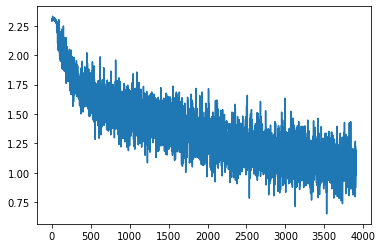

In [17]:
plt.plot(epoch_loss_all)

In [18]:
np.sum(np.diag(cm))/10000

0.6211